In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import vector
from tqdm.notebook import tqdm
from scipy import stats
import uproot
import phik
import seaborn as sns

In [2]:
file = uproot.open("DM.root")

In [3]:
df_DM = file['LHE'].arrays(file['LHE'].keys(), library="pd")
df_DM['M_phi'] = np.sqrt(df_DM['E_phi']**2 - (df_DM['p_phi_x']**2 + df_DM['p_phi_y']**2 + df_DM['p_phi_z']**2))
df_DM = df_DM.drop(columns=["p_phi_x", "p_phi_y", "p_phi_z"])

In [6]:
df_DM.describe()

p_nu_x         p_nu_y         p_nu_z          E_phi  \
count  967787.000000  967787.000000  967787.000000  967787.000000   
mean        0.087202       0.055467       0.331590     686.215951   
std        85.465135      85.739352     181.087661     296.737084   
min     -1252.031982   -1441.141235   -2791.184326     400.008850   
25%       -37.154646     -37.105282     -58.401415     487.515045   
50%         0.055620       0.006382      -0.037179     590.693909   
75%        37.120495      37.113876      58.888803     779.631622   
max      1198.657959    1111.807007    3404.349365    4278.469238   

              pt_phi        eta_phi        phi_phi          M_phi  \
count  967787.000000  967787.000000  967787.000000  967787.000000   
mean      257.754077       0.005904       0.001036     400.000000   
std       176.215133       1.525216       1.812978       0.000070   
min         0.187432      -7.865938      -3.141589     399.997043   
25%       134.056031      -1.104154      -1.568124     399.999983   
50%       218.739473       0.007594       0.001618     400.000000   
75%       336.716652       1.117865       1.571196     400.000017   
max      2671.491121       8.035368       3.141585     400.001976   

               p_l_x          p_l_y  ...        SP_QNu             Ht  \
count  967787.000000  967787.000000  ...  9.677870e+05  967787.000000   
mean       -0.019307      -0.006063  ...  1.694471e+05     278.051195   
std        92.939578      92.895006  ...  3.553419e+05     151.898216   
min     -1370.613281   -1533.586182  ...  9.958203e-01      16.400344   
25%       -41.713205     -41.806379  ...  2.617100e+04     175.111659   
50%         0.028209      -0.008821  ...  6.919527e+04     241.644764   
75%        41.808249      41.769297  ...  1.767026e+05     340.520997   
max      1197.543457    1234.371338  ...  3.953266e+07    3650.565123   

               S_hat      Dphi_LepQ    Dphi_LepNu        Dphi_Wb  \
count  967787.000000  967787.000000  9.677870e+05  967787.000000   
mean      819.401524       1.613203  2.335517e+00       2.293937   
std       492.419726       0.907158  7.793710e-01       0.820639   
min       113.538028       0.000001  5.974573e-07       0.000015   
25%       481.823345       0.832754  1.980200e+00       1.864517   
50%       693.268286       1.637502  2.619457e+00       2.599093   
75%      1015.223414       2.403002  2.926323e+00       2.938217   
max      9399.953511       3.141589  3.141592e+00       3.141592   

             DR_LepQ       DR_LepNu          DR_Wb  Cos_lep_light  
count  967787.000000  967787.000000  967787.000000  967787.000000  
mean        3.187033       2.470702       2.696760       0.310900  
std         1.184840       0.634858       0.790709       0.487353  
min         0.003748       0.127668       0.006452      -0.999984  
25%         2.394747       2.123523       2.313089      -0.034832  
50%         3.159179       2.660092       2.879034       0.394990  
75%         3.945025       2.947233       3.147469       0.722847  
max        12.505516       7.931193       9.190281       0.999999  

[8 rows x 52 columns]

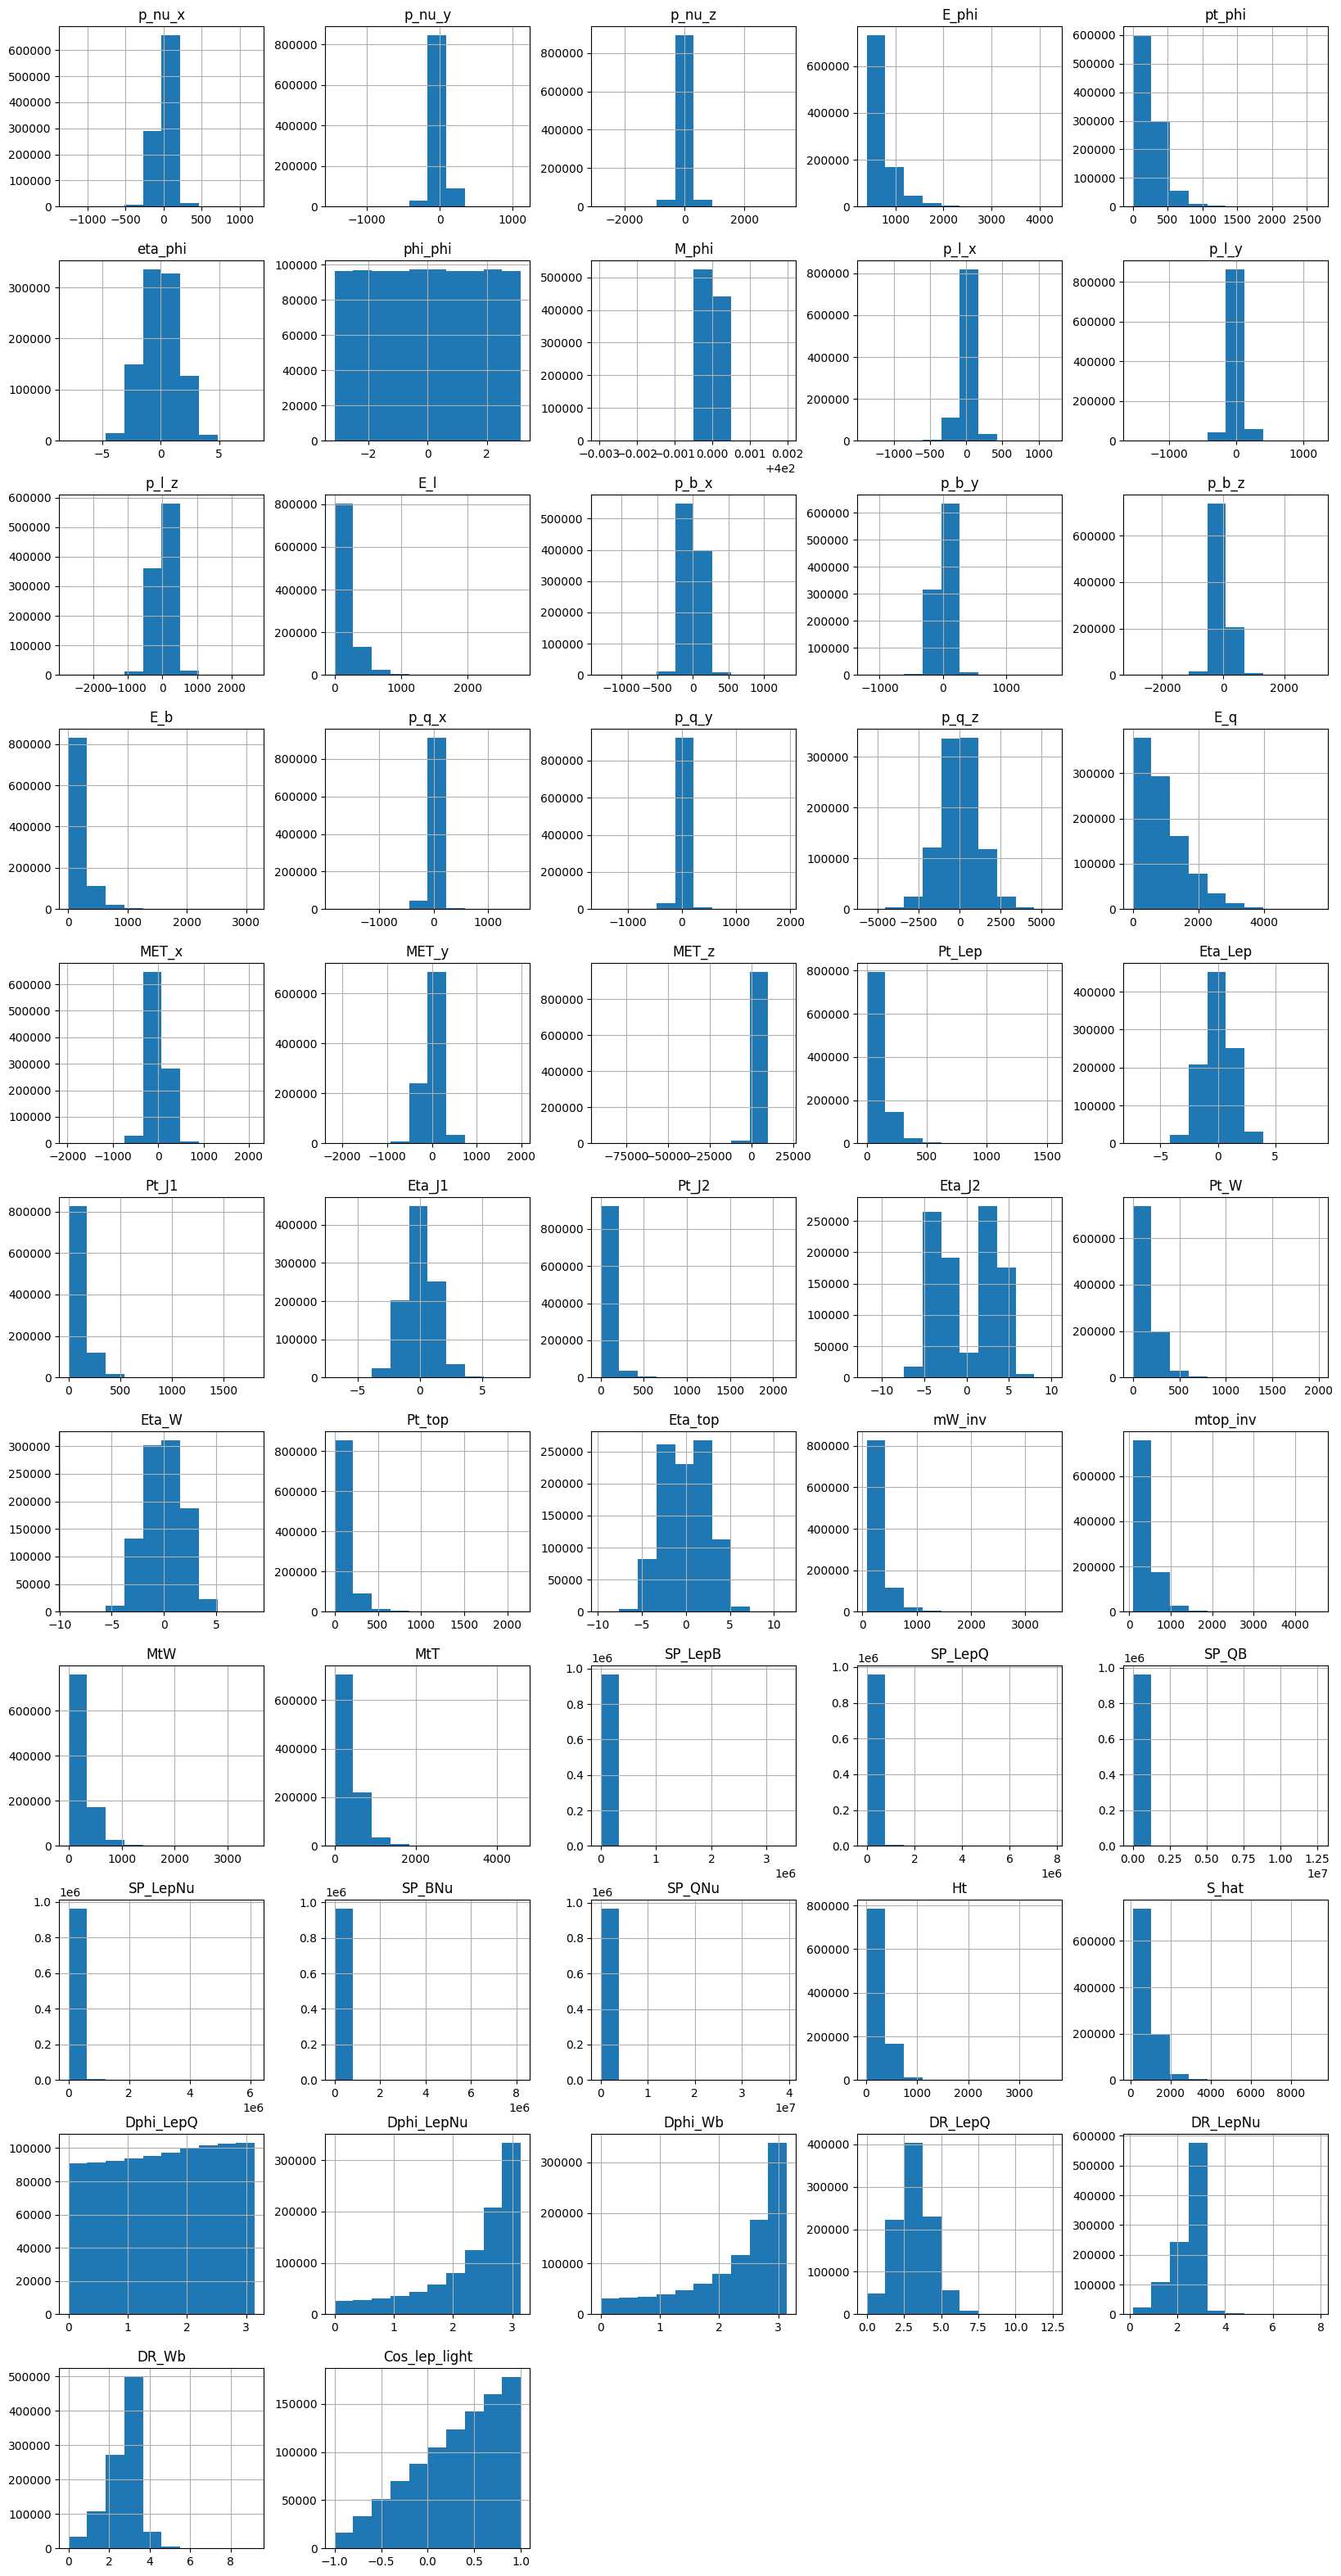

In [7]:
df_DM.hist(figsize=(20, 40), layout=(-1, 5))
plt.show()

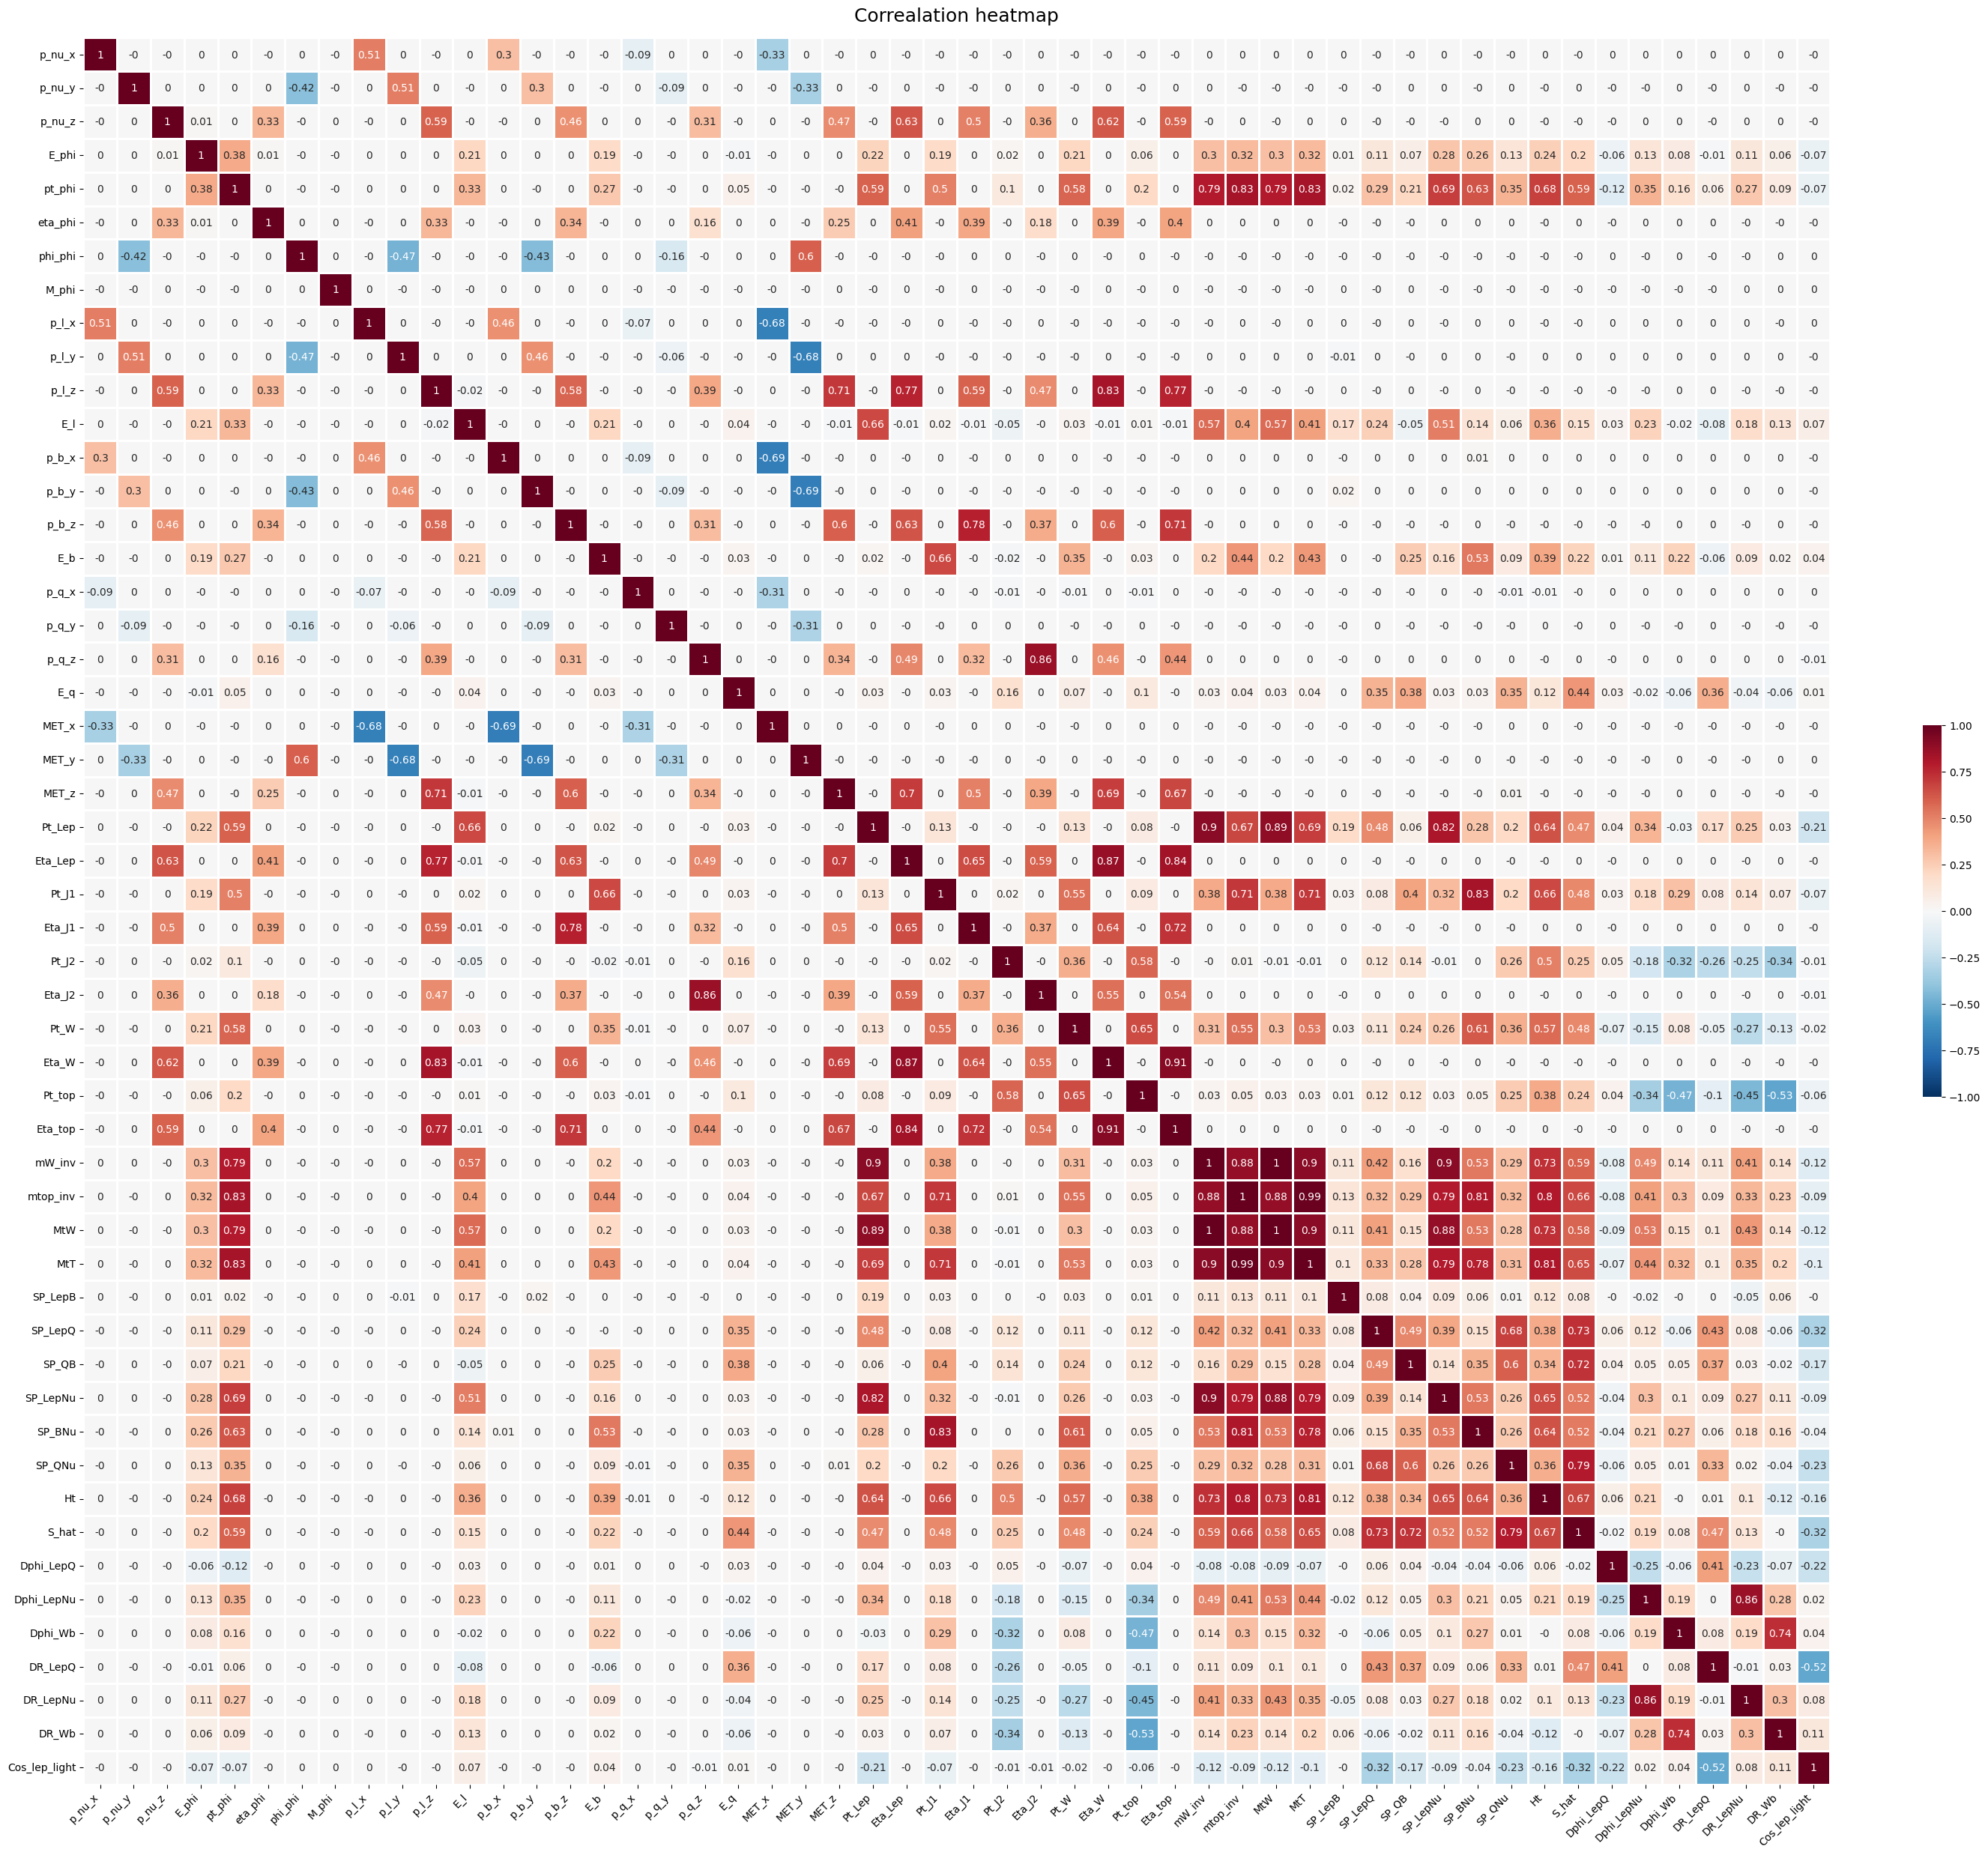

In [41]:
plt.figure(figsize=(32, 32))

heatmap = sns.heatmap(
    df_DM.corr(method="pearson", numeric_only=True).round(2),
    annot=True,
    square=True,
    cmap="RdBu_r",
    vmax=1,
    vmin=-1,
    cbar_kws={"fraction": 0.01},  # shrink colour bar
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Correalation heatmap", fontdict={"fontsize": 18}, pad=16)
plt.show()

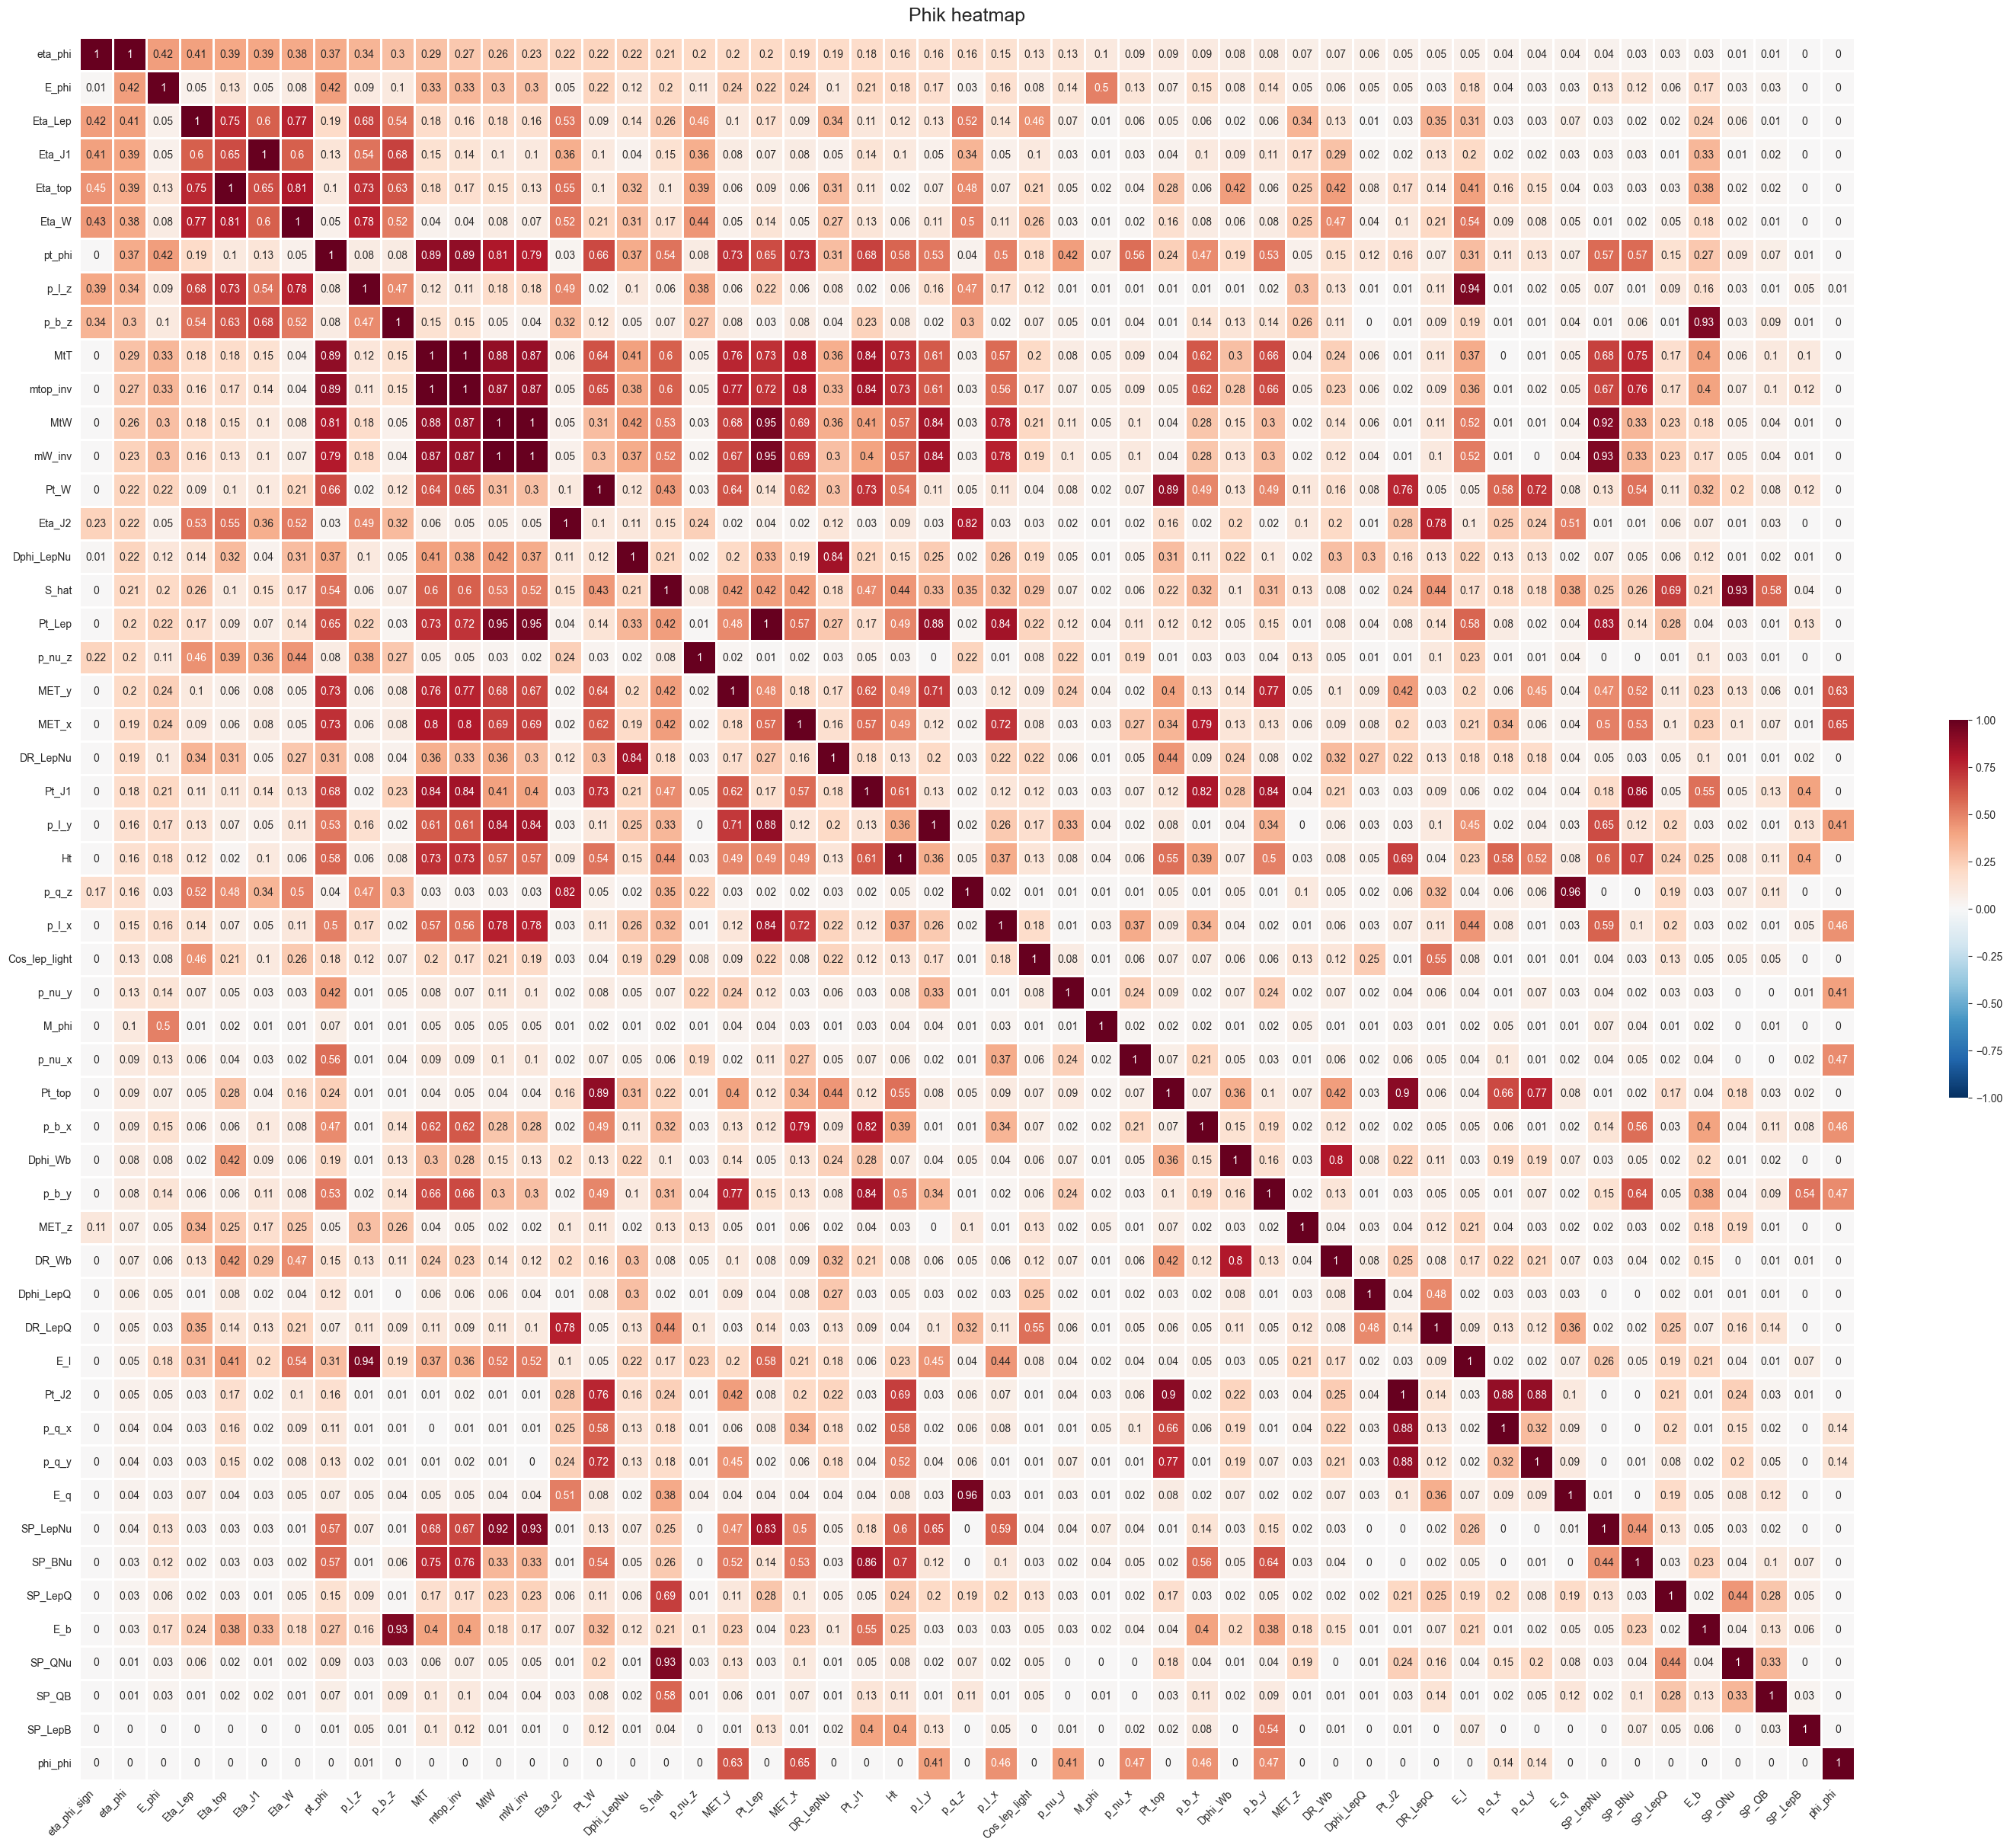

In [20]:
plt.figure(figsize=(32, 32))
heatmap = sns.heatmap(
    df_DM.phik_matrix(interval_cols=df_DM.columns)
    .round(2)
    .sort_values("eta_phi", ascending=False, axis=1)
    .reindex(sotred_columns),
    annot=True,
    square=True,
    cmap="RdBu_r",
    vmax=1,
    vmin=-1,
    cbar_kws={"fraction": 0.01},  # shrink colour bar
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Phik heatmap", fontdict={"fontsize": 18}, pad=16)
plt.show()

In [10]:
df_DM['eta_phi_sign'] = np.sign(df_DM['eta_phi'])
df_DM['eta_phi_sign'] = ((df_DM['eta_phi_sign']+1)/2).astype(int)

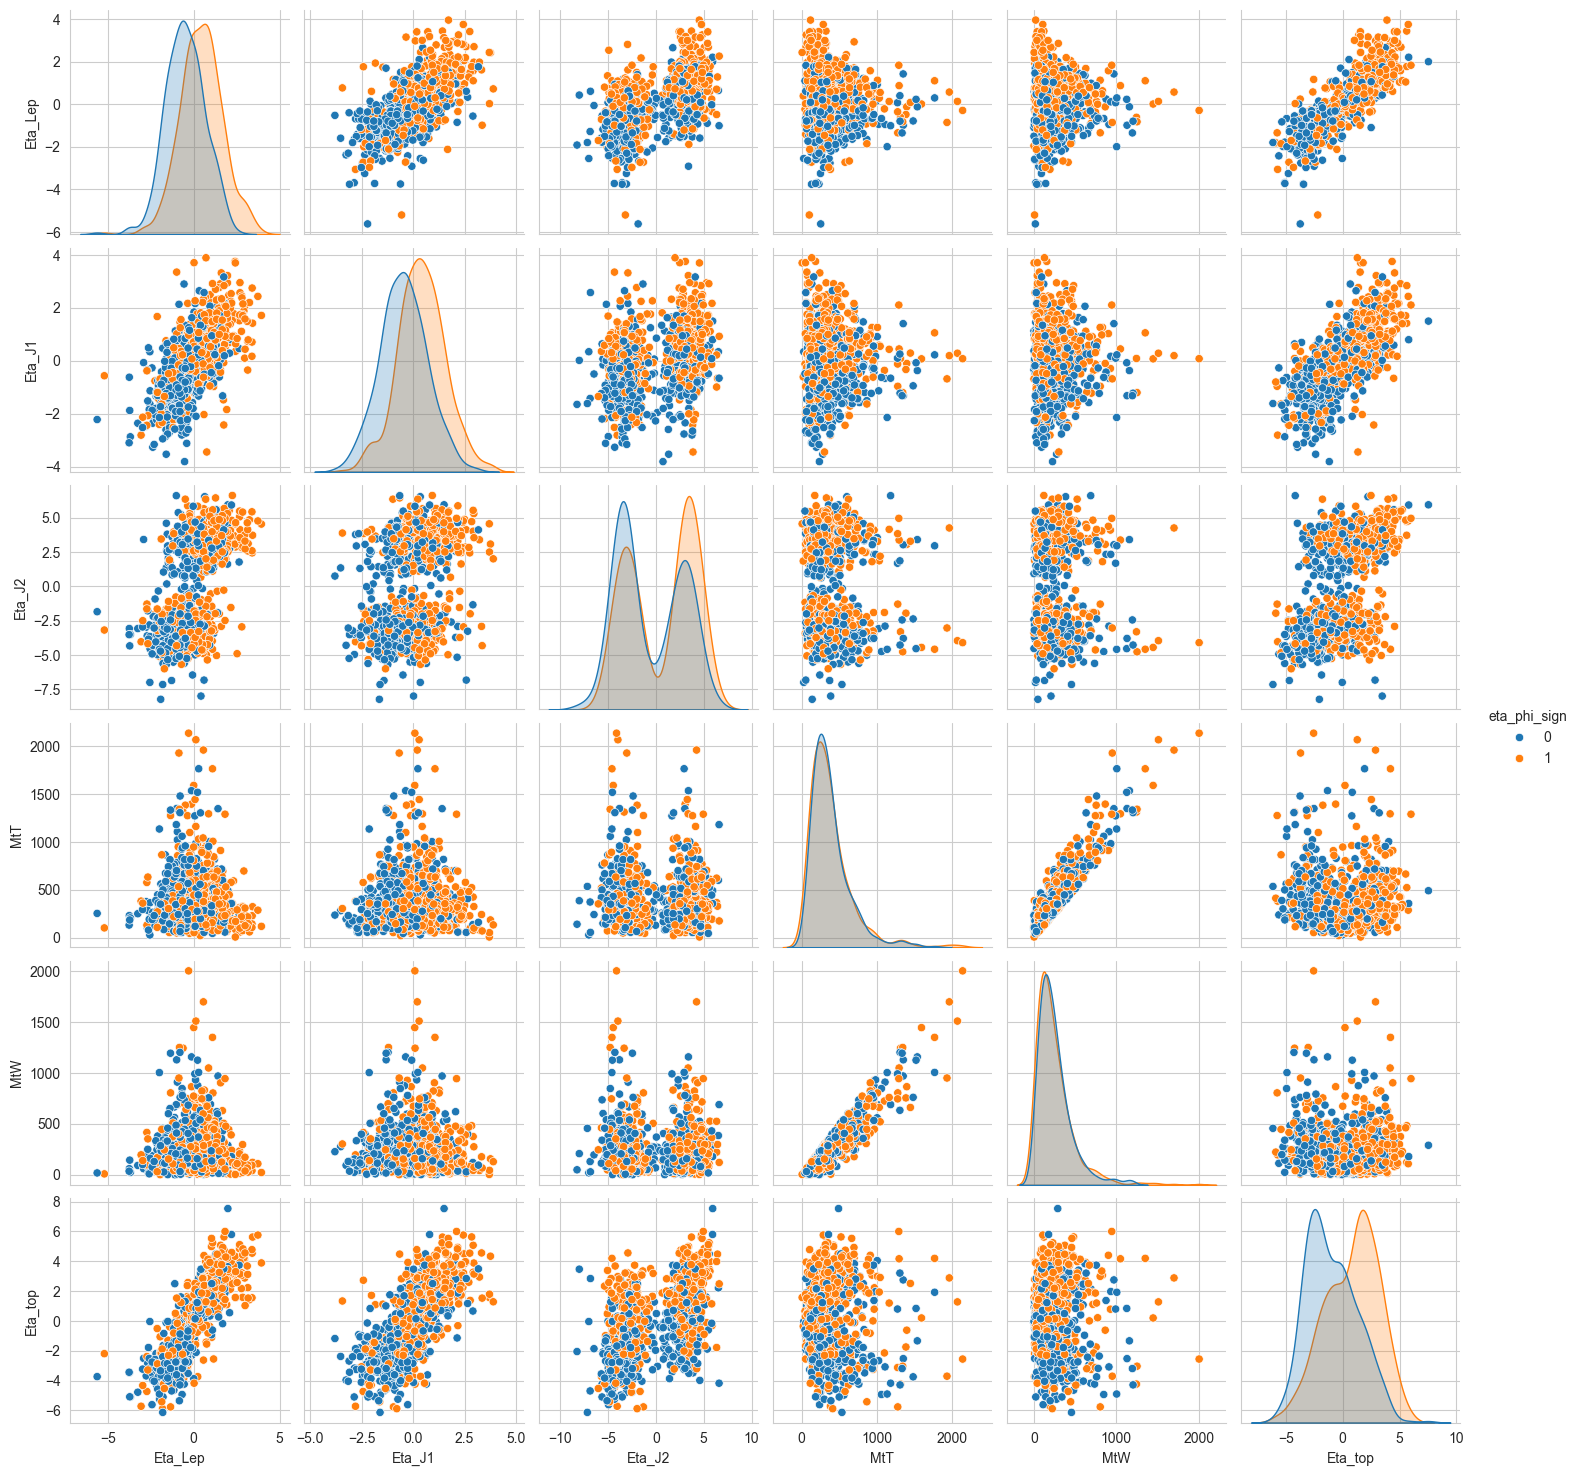

In [21]:
sns.set_style("whitegrid")

sns.pairplot(
    df_DM.sample(1000),
    vars=["Eta_Lep", "Eta_J1", "Eta_J2", "MtT", "MtW", "Eta_top"],
    hue="eta_phi_sign",
)
plt.show()

In [22]:
from sklearn.decomposition import PCA

In [23]:
y_vars = ['eta_phi_sign']

X_vars = ['p_l_x', 'p_l_y', 'p_l_z', 'p_b_x', 'p_b_y', 'p_b_z', 'p_q_x', 'p_q_y',
          'p_q_z', 'MET_x', 'MET_y', 'MET_z', 'Pt_Lep', 'Eta_Lep', 'Pt_J1', 'Eta_J1',
          'Pt_J2', 'Eta_J2', 'Pt_W', 'Eta_W', 'Pt_top', 'Eta_top', 'mW_inv', 'mtop_inv',
          'MtW', 'MtT', 'SP_LepB', 'SP_LepQ', 'SP_QB', 'SP_LepNu', 'SP_BNu', 'SP_QNu',
          'Ht', 'S_hat', 'Dphi_LepQ', 'Dphi_LepNu', 'Dphi_Wb', 'DR_LepQ', 'DR_LepNu', 'DR_Wb']

In [24]:
train_raw_DM, test_raw_DM = train_test_split(df_DM, test_size=0.2)
X_train_df = train_raw_DM[X_vars]
X_test_df = test_raw_DM[X_vars]
y_train_df = train_raw_DM[y_vars]
y_test_df = test_raw_DM[y_vars]

In [25]:
scaler_X = StandardScaler()
scaler_X.fit(np.array(train_raw_DM[X_vars]))
X_train_df = pd.DataFrame(scaler_X.transform(np.array(train_raw_DM[X_vars])), columns=X_vars)
X_test_df = pd.DataFrame(scaler_X.transform(np.array(test_raw_DM[X_vars])), columns=X_vars)

In [26]:
pca = PCA(n_components=10)
pca.fit(X_train_df)

PCA(n_components=10)

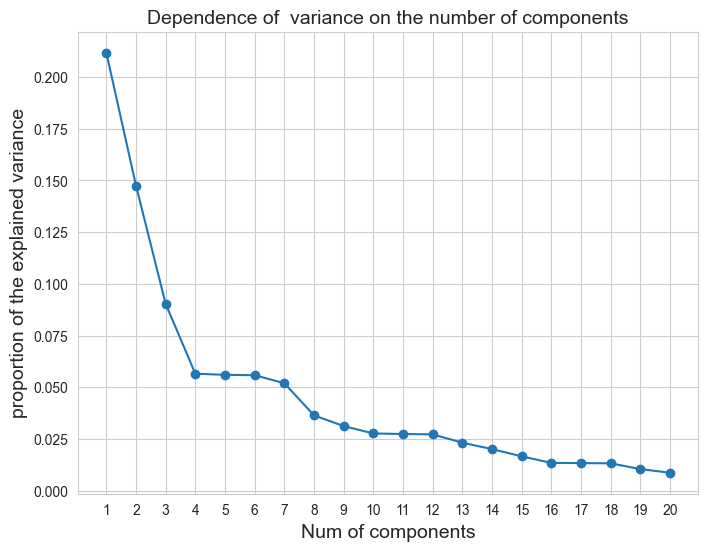

In [28]:
n_comp = 20
pca = PCA(n_comp)
pca.fit(X_train_df)
explained = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.scatter(np.arange(1, n_comp + 1), explained)
plt.plot(np.arange(1, n_comp + 1), explained)
plt.title("Dependence of  variance on the number of components", size=14)
plt.xlabel("Num of components", size=14)
plt.ylabel("proportion of the explained variance", size=14)
plt.xticks(np.arange(1, n_comp + 1))
plt.show()

In [32]:
from IPython.display import clear_output
from umap import UMAP

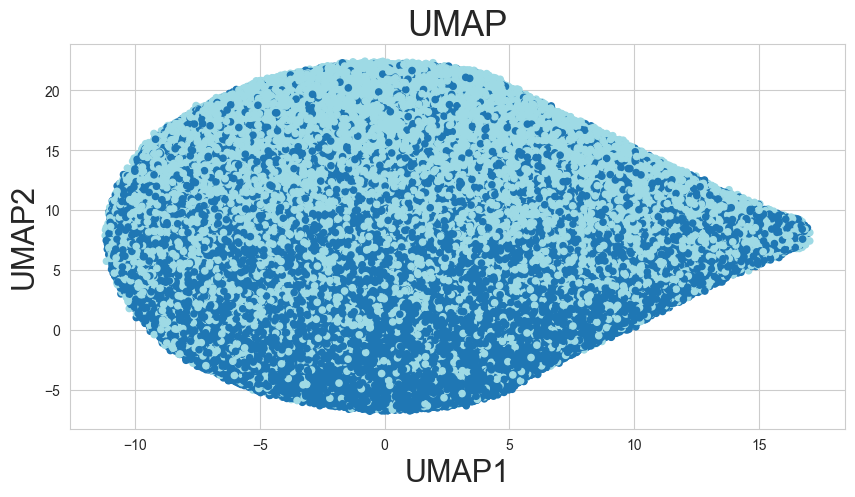

In [33]:
x_reduced = PCA(n_components=4).fit_transform(X_train_df) 

model = UMAP(
    n_components=2,
    min_dist=1,
    n_neighbors=100,
    init=x_reduced[:, 0:2],
    n_epochs=100,
    verbose=2,
)

# Runs the UMAP algorithm on the PCA transformed data
umap = model.fit_transform(x_reduced)
clear_output()
# Plots the results of the UMAP transformation
plt.figure(figsize=(10, 5))
plt.scatter(umap[:, 0], umap[:, 1], c=y_train_df.values, cmap="tab20", s=20)
plt.title("UMAP", fontsize=25)
plt.xlabel("UMAP1", fontsize=22)
plt.ylabel("UMAP2", fontsize=22)
plt.show()